# PS reconstruction, Gaussian beam

In [1]:
import torch
from copy import deepcopy

import lightning as L

from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Import data

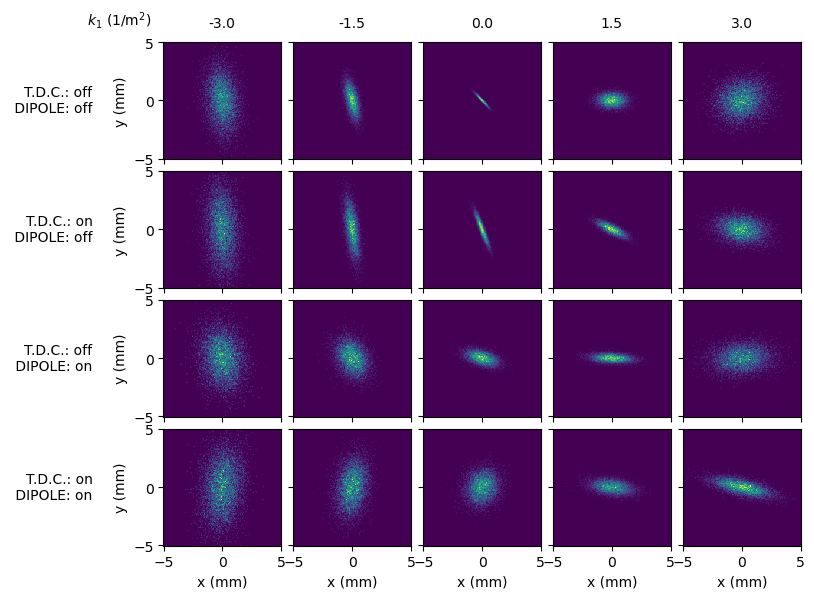

In [2]:
obs_dataset = torch.load("example_data/example_datasets/reconstruction_6D.dset", weights_only=False)
obs_dataset.plot_data(publication_size=True);

## Set up diagnostic lattice in cheetah
These parameters match those at the Argonne Wakefield Accelerator (AWA) and were used
 to generate the synthetic example dataset.

In [3]:
p0c = 43.36e6  # reference momentum in eV/c

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(obs_dataset.screens[0]),
    deepcopy(obs_dataset.screens[1]),
)

## Training using pytorch lightning

In [4]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=10)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/gpsr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging int

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, v_num=160]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, v_num=160]


In [5]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

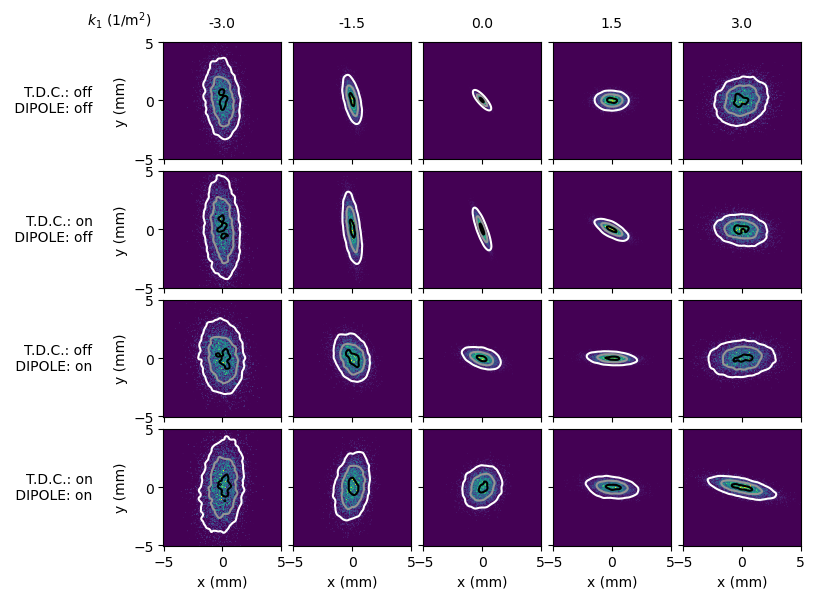

In [6]:
train_params = obs_dataset.six_d_params
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, obs_dataset.screens)
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap": "Greys", "levels": [0.1, 0.5, 0.9]},
    filter_size=3
);

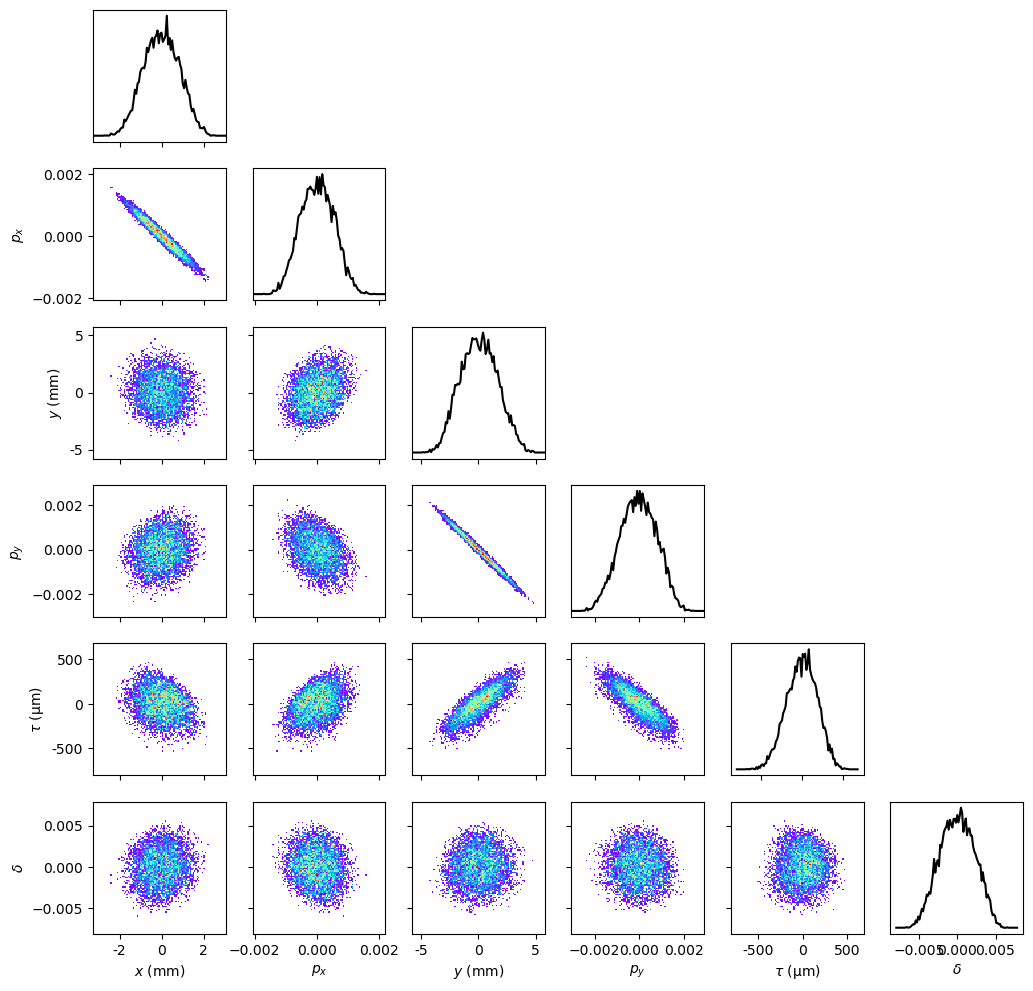

In [7]:
reconstructed_beam.plot_distribution();